# CITS5508 Lab 4: Random Forest Regression on Abalone Ring Count

Name: Joey Koh<br>
Student number: 21506379  
Date created: 13 April 2020  
Last modified: 20 April 2020  

This notebook compares the performance of a Random Forest regressor with and without dimensionality reduction. It is addressing a regression task on predicting abalone ring count using various attribute inputs.<br>

Todo:
- [ ] Search for and answer "HELP"
- [ ] fix the histogram offcentre

Ask:
- calc MSE from rounded pred or unrounded? ANS: From rounded right?

    Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years

## 1. Setup, Inspection and Cleaning

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
#from pandas.plotting import scatter_matrix
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import warnings
#warnings.filterwarnings("ignore") #clear warnings

#Prepare the data, give headings from data information
raw_data = pd.read_csv("abalone.data",
                      header=None,
                      names=['sex','length','diameter','height','whole weight','shucked weight','viscera weight','shell weight','rings']
                      )

#View first few lines and inspect columns
raw_data.head()


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


The 'sex' feature is text-based categorical data, we need to 

In [2]:
#need to add headings, drop low label counts, rearrange index,
#one hot encode the sex feature?
#no need to feature scale since tree based

In [3]:
#HELP visualisations of cols
#plt.hist(raw_data)
#plt.show()

In [4]:
#Looking at the label distribution
raw_data["rings"].value_counts()

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
24      2
27      2
1       1
25      1
2       1
26      1
29      1
Name: rings, dtype: int64

From the label instances.<br>
Let's **remove all labels with less than 10 instances** as the small sample size making it unfeasible for fitting.

In [5]:
#i.e. remove all rows with 'ring' label = 23,22,24,27,1,25,2,26 or 29
#Meaning keep all less than 22, and all greater than 2.
#HELP: correct to use > or < as this is an integer not a class right? for future data
data = raw_data[(raw_data['rings'] >2) & (raw_data['rings'] <22)]
data = data.reset_index(drop=True)


In [6]:
data['sex'].value_counts()

M    1519
I    1340
F    1294
Name: sex, dtype: int64

In [7]:
data['sex'].values.reshape(-1,1)

array([['M'],
       ['M'],
       ['F'],
       ...,
       ['M'],
       ['F'],
       ['M']], dtype=object)

In [8]:
#Define encoder
enc = OneHotEncoder(handle_unknown='ignore')

#Get array of transformed categories
s_trans = enc.fit_transform(data['sex'].values.reshape(-1,1)).toarray() 

#Check order of categories for headings
print(enc.categories_)
s_onehot = pd.DataFrame(s_trans, columns= ['sex F','sex I','sex M'])

#Concatenate new one-hot encoded columns and remove predecessor column
data_enc = pd.concat([s_onehot,data], axis=1)
data_enc = data_enc.drop('sex', axis=1)

#Check first few rows
data_enc.head()

[array(['F', 'I', 'M'], dtype=object)]


,sex F,sex I,sex M,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,0.0,0.0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.0,0.0,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1.0,0.0,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.0,0.0,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.0,1.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [9]:
"""
from sklearn.compose import ColumnTransformer 
ct = ColumnTransformer( [("sex 1hotencode",OneHotEncoder(),[0])], remainder="passthrough") # column transform with onehotencoder the first column only
data = ct.fit_transform(data)    
""";

In [10]:
#new_headings = list(range(3)).extend(raw_data.columns)
#print(new_headings)

In [11]:
#restored = pd.DataFrame(data, columns = new_headings)


## 2. Data Split

In [12]:
#Separate labels and features
y= data_enc['rings']
X= data_enc.drop('rings',axis=1)
#split dataset at 85/15 ratio
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size= 0.15, random_state= 0)


## 3. Random Forest Regressor
Decision Tree based on splitting within a random subset of features

In [13]:
#functions used
def displayMSE(title, mse): #function for plotting and printing Mean Sq Errors
    plt.scatter(list(range(1,7)), mse)
    plt.plot(list(range(1,7)), mse)
    plt.title(title)
    plt.ylabel('MSE')
    plt.xlabel('Estimator no.')
    plt.show()
    print("These are the MSEs for each estimator model from first to last:")
    print(mse)
    
def getPredictionAndErrors(model, features_X, labels_y): #returns raw prediciton errors
    pred = model.predict(features_X) #get prediction values
    pred_round = pred.round() #round predictions and change to integers
    pred_round = pred_round.astype("int64")
    raw_errors = pred_round - labels_y #compute raw prediction errors
    mse = mean_squared_error(labels_y,pred_round)
    return pred_round, mse, raw_errors

def displayRawErrors(raw_errors,title): #plots raw error histogram
    raw_errors.hist(align= "mid")
    #np.histogram(raw_errors, bins=50)
    #plt.bar(raw_errors)
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Raw Error of Quality")
    plt.show()

In [14]:
#Prepare regressor
rfor_reg = RandomForestRegressor(n_estimators=50,
                                max_leaf_nodes=16,
                                n_jobs=-1)

rfor_reg.fit(train_X,train_y) #fit on training set

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=16,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
test_pred, test_mse, test_raw_error = getPredictionAndErrors(rfor_reg, test_X, test_y)
train_pred, train_mse, train_raw_error = getPredictionAndErrors(rfor_reg, train_X, train_y)

print(test_mse, train_mse)


4.886035313001605 3.988668555240793


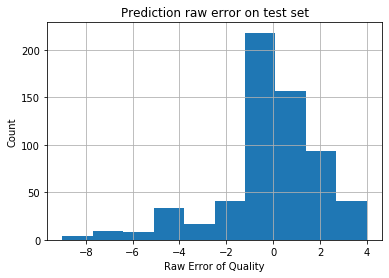

In [16]:
displayRawErrors(test_raw_error,"Prediction raw error on test set")

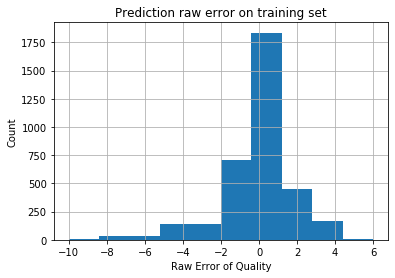

In [17]:
displayRawErrors(train_raw_error,"Prediction raw error on training set")

### 3.1 Feature Importance

In [18]:
#DU ANS: at least say you used a calculator and found that these ft summed to etc and then you can remove
# try numpy.argsort
for name, score in zip(data_enc.columns, rfor_reg.feature_importances_.round(4)):
    print(name,score)

sex F 0.0002
sex I 0.0293
sex M 0.0002
length 0.0066
diameter 0.0052
height 0.0083
whole weight 0.0081
shucked weight 0.12
viscera weight 0.0062
shell weight 0.8157


In [19]:
a = []
for name, score in zip(data_enc.columns, rfor_reg.feature_importances_.round(4)):
    a.append(name)
    a.append(score)
    print(name,score)

sex F 0.0002
sex I 0.0293
sex M 0.0002
length 0.0066
diameter 0.0052
height 0.0083
whole weight 0.0081
shucked weight 0.12
viscera weight 0.0062
shell weight 0.8157


In [20]:
a

['sex F',
 0.0002,
 'sex I',
 0.0293,
 'sex M',
 0.0002,
 'length',
 0.0066,
 'diameter',
 0.0052,
 'height',
 0.0083,
 'whole weight',
 0.0081,
 'shucked weight',
 0.12,
 'viscera weight',
 0.0062,
 'shell weight',
 0.8157]

The first 3 columns are from one-hot encoding the 'feature'. Hence, this means that 

## 4. Feature Trimming

from sklearn.feature_selection import SelectFromModel

sel_rfor = SelectFromModel(rfor_reg,
                          threshold= 0.02)
sel_rfor.fit(train_X,train_y)

sel_rfor.get_support()

test_pred_sel, test_mse_sel, test_raw_error_sel = getPredictionAndErrors(sel_rfor, test_X, test_y)
train_pred_sel, train_mse_sel, train_raw_error_sel = getPredictionAndErrors(sel_rfor, train_X, train_y)

print(test_mse_sel, train_mse_sel)


From previous section, the feature importances that contribute to the 95% threshold are 'shell weight','shucked weight', and 'sex'<br>
#HELP how to deal with the sex contribution? together?<br>

Let's drop all features besides these

In [21]:
train_X

,sex F,sex I,sex M,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight
534,0.0,0.0,1.0,0.320,0.245,0.075,0.1555,0.0585,0.0380,0.0490
1900,1.0,0.0,0.0,0.600,0.470,0.135,0.9700,0.4655,0.1955,0.2640
4053,0.0,1.0,0.0,0.550,0.435,0.125,0.7410,0.3480,0.1585,0.2060
1328,0.0,0.0,1.0,0.585,0.460,0.165,1.1135,0.5825,0.2345,0.2740
3462,1.0,0.0,0.0,0.505,0.475,0.160,1.1155,0.5090,0.2390,0.3065
...,...,...,...,...,...,...,...,...,...,...
1033,0.0,0.0,1.0,0.710,0.565,0.205,2.1980,1.0120,0.5225,0.5475
3264,1.0,0.0,0.0,0.605,0.475,0.145,1.0185,0.4695,0.2250,0.2700
1653,0.0,0.0,1.0,0.610,0.475,0.155,0.9830,0.4565,0.2280,0.2660
2607,0.0,1.0,0.0,0.330,0.240,0.075,0.1630,0.0745,0.0330,0.0480


In [22]:
#Reduce feature columns as stated
test_X_new = test_X[['shucked weight','shell weight']]
train_X_new = train_X[['shucked weight','shell weight']]

In [23]:
#Fit previous model on new training set
rfor_reg.fit(train_X_new,train_y) #fit on training set

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=16,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [24]:
test_pred_new, test_mse_new, test_raw_error_new = getPredictionAndErrors(rfor_reg, test_X_new, test_y)
train_pred_new, train_mse_new, train_raw_error_new = getPredictionAndErrors(rfor_reg, train_X_new, train_y)

print(test_mse_new, train_mse_new)


5.057784911717496 4.148158640226629


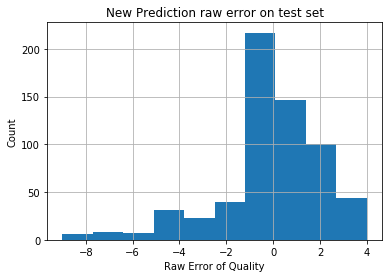

In [25]:
displayRawErrors(test_raw_error_new,"New Prediction raw error on test set")

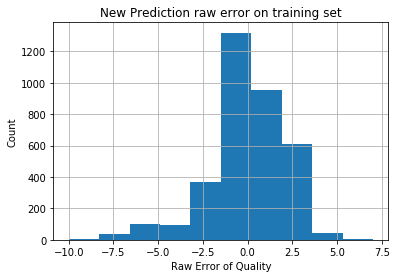

In [26]:
displayRawErrors(train_raw_error_new,"New Prediction raw error on training set")
